In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from imblearn.pipeline import make_pipeline as make_imb_pipeline

def run_knn_analysis(X_train, y_train, param_grid={}, seed=123, preprocessor=None, scoring=None):
    """
    Perform Hyperparameter Optimization for k-Nearest Neighbors on the given data.
    
    Parameters
    ----------
    X_train : pd.DataFrame
        Training data 
    y_train : pd.Series
        Target values 
    param_grid : dict
        Parameter grid for k-Nearest Neighbors
    preprocessor : ColumnTransformer object
        A callable preprocessor function that transforms the training data.
    scoring : dict or str
        Scoring strategy to evaluate the performance of the cross-validated model.
    
    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the results of the k-Nearest Neighbors analysis.
    """
    results = []

    for k in param_grid["n_neighbors"]:
        knn = KNeighborsClassifier(n_neighbors=k)

        pipe = make_pipeline(preprocessor, knn)
        scores = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=scoring, cv=20)

        # Store the results for each k
        k_results = {"n_neighbors": k, "kNN model": "without oversampling"}
        for metric in scoring.keys():
            test_metric = f"test_{metric}"
            k_results[f"mean_{metric}"] = np.mean(scores[test_metric])
            k_results[f"std_{metric}"] = np.std(scores[test_metric])

        results.append(k_results)
        
        pipe_imb = make_imb_pipeline(RandomOverSampler(sampling_strategy='minority'), preprocessor, knn)
        scores = cross_validate(pipe_imb, X_train, y_train, return_train_score=True, scoring=scoring, cv=20)

        # Store the results for each k
        k_results = {"n_neighbors": k, "kNN model": "with oversampling"}
        for metric in scoring.keys():
            test_metric = f"test_{metric}"
            k_results[f"mean_{metric}"] = np.mean(scores[test_metric])
            k_results[f"std_{metric}"] = np.std(scores[test_metric])

        results.append(k_results)

    # Convert the results to a pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [4]:
import os
import sys
import click
import pickle
import pandas as pd
import numpy as np
from joblib import load
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import altair as alt

def main(x_train, y_train, preprocessor, table_results_to, figure_results_to):
    '''Finds the best k for KK, fits the disease classifier to the training data and saves the pipeline object and cv_results.'''
    #import X_train and y_train
    x_train = pd.read_csv(x_train)
    y_train = pd.read_csv(y_train)

    #load the preprocessor
    # Load the preprocessor
    with open(preprocessor, 'rb') as f:
        preprocessor = pickle.load(f)
    print(f"Loaded Preprocessor: {preprocessor}")  # Debug print

    scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, pos_label=1),
        'recall': make_scorer(recall_score, pos_label=1),
        'f1_score': make_scorer(f1_score, pos_label=1)
    }
    
    #Search the best k for knn
    param_grid = {"n_neighbors": np.arange(1, 20, 1)}
    df_cv_knn = run_knn_analysis(x_train, y_train, param_grid, 
                                 preprocessor=preprocessor, scoring=scoring_metrics)


    df_cv_knn.to_csv(os.path.join(table_results_to, "result_knn.csv"), index=False)

    accuracy_chart = alt.Chart(df_cv_knn).mark_line(point=True).encode(
        x=alt.X('n_neighbors:O', title='Neighbors', axis=alt.Axis(labelAngle=0)), 
        y=alt.Y('mean_accuracy:Q', title='Accuracy'),
        color='kNN model:N',
    )

    error_bars_acc = alt.Chart(df_cv_knn).mark_errorbar(extent='ci').encode(
        x=alt.X('n_neighbors:O', title=''), 
        y=alt.Y('mean_accuracy:Q', title=''),
        yError='std_accuracy:Q',
        color='kNN model:N'
    )

    # Create the line chart for recall with error bars
    recall_chart = alt.Chart(df_cv_knn).mark_line(point=True).encode(
        x=alt.X('n_neighbors:O', title='Neighbors', axis=alt.Axis(labelAngle=0)), 
        y=alt.Y('mean_recall:Q', title='Recall'),
        color='kNN model:N',
    )

    error_bars_rec = alt.Chart(df_cv_knn).mark_errorbar(extent='ci').encode(
        x=alt.X('n_neighbors:O', title=''), 
        y=alt.Y('mean_recall:Q', title=''),
        yError='std_recall:Q',
        color='kNN model:N'
    )

    # Combine the charts side by side
    accuracy_chart = accuracy_chart + error_bars_acc
    recall_chart = recall_chart + error_bars_rec

    # Save the chart
    accuracy_chart.save(os.path.join(figure_results_to, "accuracy_lines.png"),
              scale_factor=2.0)
    recall_chart.save(os.path.join(figure_results_to, "recall_lines.png"),
              scale_factor=2.0)

In [5]:
main('../data/processed/X_train.csv', '../data/processed/y_train.csv', preprocessor='../results/models/preprocessor.pickle', table_results_to='../results/tables/', figure_results_to='../results/figures/')

Loaded Preprocessor: ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE', 'FRW', 'SBP', 'DBP', 'CHOL', 'CIG']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['sex'])])


c:\Users\doris\miniconda3\envs\573\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\doris\miniconda3\envs\573\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\doris\miniconda3\envs\573\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\doris\miniconda3\envs\573\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected

In [26]:
import os
import sys
import click
import pickle
import pandas as pd
import numpy as np
from joblib import load
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from math import pi

def main(x_train, y_train, preprocessor, figure_results_to):
    # Import data
    x_train = pd.read_csv(x_train)
    y_train = pd.read_csv(y_train).squeeze()

    # Load the preprocessor
    with open(preprocessor, 'rb') as f:
        preprocessor = pickle.load(f)

    # Instantiate and fit the kNN model
    knn = KNeighborsClassifier(n_neighbors=9)
    pipe_imb = make_imb_pipeline(RandomOverSampler(sampling_strategy='minority'), preprocessor, knn)
    pipe_imb.fit(x_train, y_train)

    # Compute permutation importances
    perm_importance = permutation_importance(pipe_imb, x_train, y_train, n_repeats=30, random_state=123)

    # Create DataFrame for feature importances
    importances_df = pd.DataFrame({
        'Feature': [name.split('__')[-1] for name in preprocessor.get_feature_names_out()],
        'Importance': perm_importance.importances_mean
    })

    # Normalize the feature importances for the radar chart
    importances_df['Importance'] /= importances_df['Importance'].max()

    # Number of variables
    categories = list(importances_df['Feature'])
    N = len(categories)

    # We need to repeat the first value to close the circular graph:
    values = importances_df['Importance'].values.flatten().tolist()
    values += values[:1]
    categories += categories[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels
    plt.xticks(angles, categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Save figure
    plt.savefig(os.path.join(figure_results_to, "radar_feature_importance.png"), bbox_inches='tight')



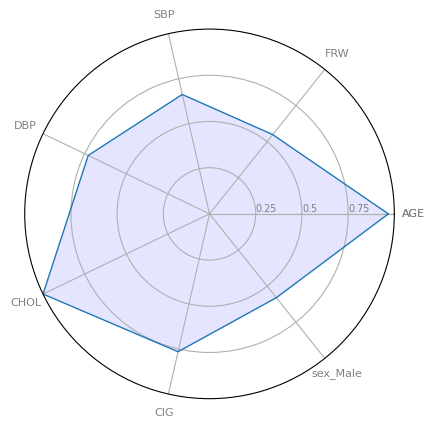

In [27]:
main('../data/processed/X_train.csv', '../data/processed/y_train.csv', preprocessor='../results/models/preprocessor.pickle', figure_results_to='../results/figures/')